In [1]:
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
VIDEOS_DIR = '../config/real/video_manifests/'
NETWORK_LOGS_DIR = '../config/real/network_traces/raw/'

In [3]:
video_dfs = []

for video in sorted(os.listdir(VIDEOS_DIR)):
    for f in os.listdir(os.path.join(VIDEOS_DIR, video)):
        json_content = json.load(open(os.path.join(VIDEOS_DIR, video, f), 'r'))
        sizes = np.array(json_content['segment_sizes_bits'])
        S, T, Q = sizes.shape
        s, t, q = np.unravel_index(range(S * T * Q), sizes.shape)
        video_dfs.append(pd.DataFrame({'video': video, 'segment': s, 'tile': t, 'quality': q + 1, 'size': sizes.flatten()}))

df_video = pd.concat(video_dfs)
df_video['timestamp'] = df_video['segment'] * 1000
df_video['size_kb'] = df_video['size'] / 1000

In [4]:
network_dfs = []

for network_file in sorted(os.listdir(NETWORK_LOGS_DIR)):
    records = json.load(open(os.path.join(NETWORK_LOGS_DIR, network_file), 'r'))
    df_file = pd.DataFrame.from_records(records)
    df_file['timestamp'] = df_file['duration_ms'].cumsum() - df_file['duration_ms']
    df_file['name'] = network_file[7:-5]
    network_dfs.append(df_file)

df_network = pd.concat(network_dfs)
df_network = df_network[df_network['timestamp'] <= df_video['timestamp'].max() + 1000]

raw bicycle_0001


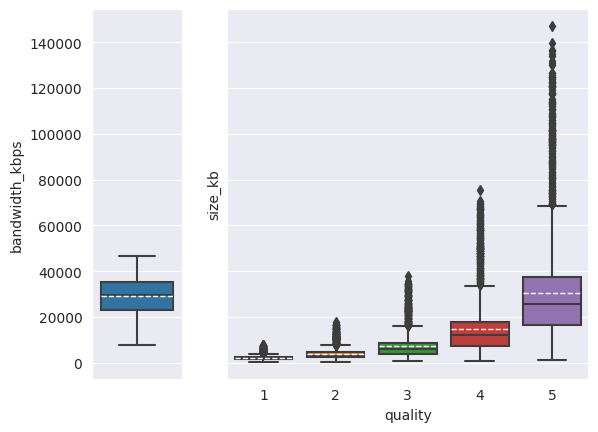

scaled bicycle_0001


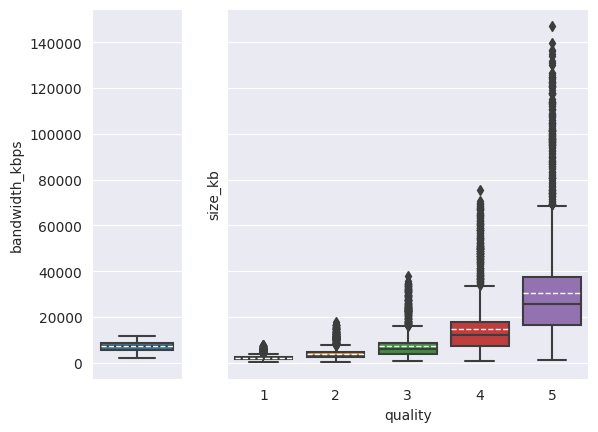

raw bicycle_0002


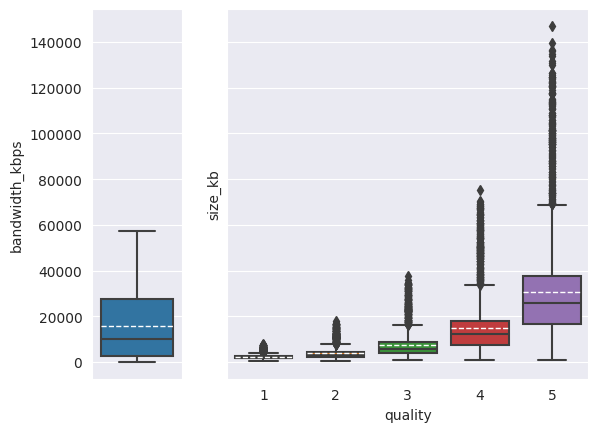

scaled bicycle_0002


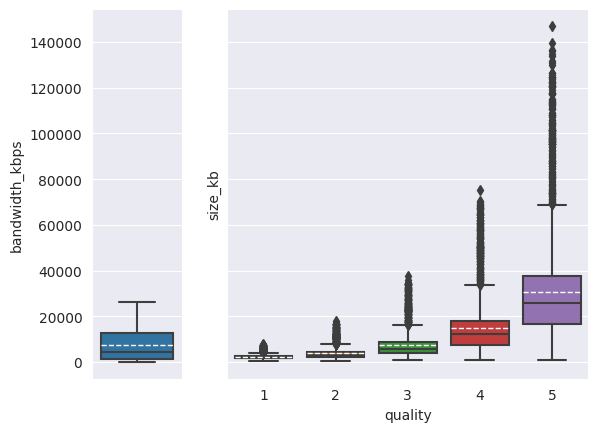

raw bus_0001


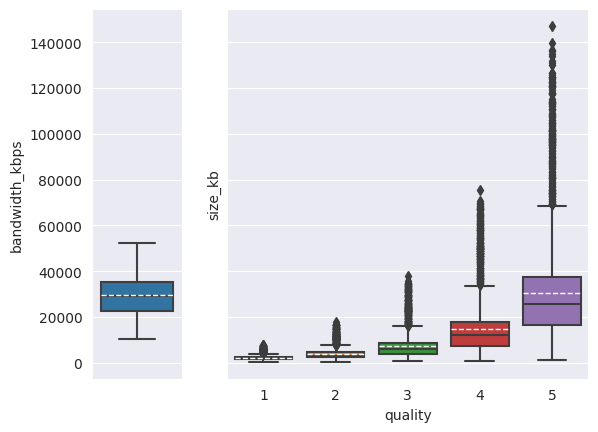

scaled bus_0001


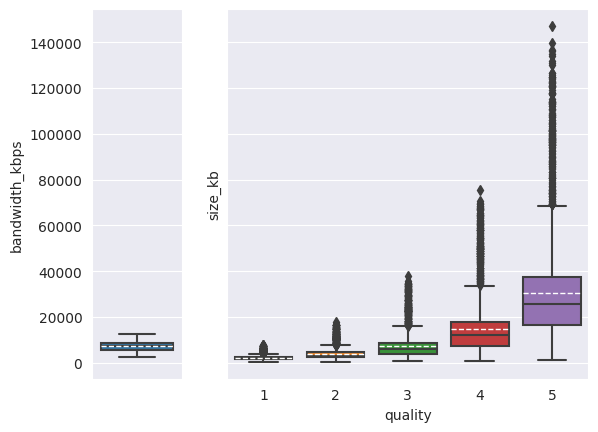

raw bus_0002


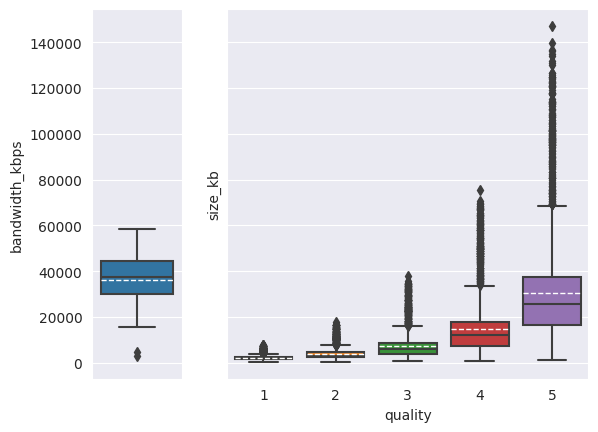

scaled bus_0002


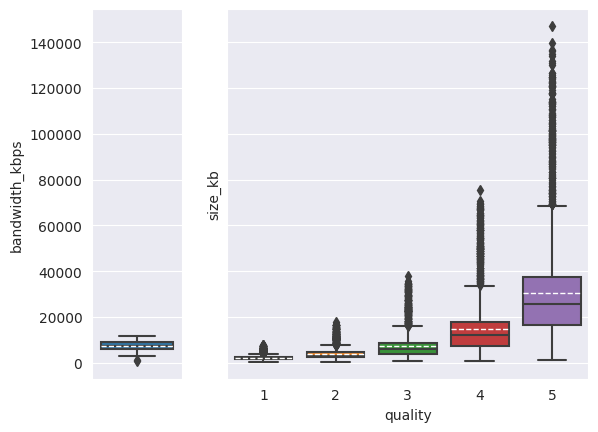

raw bus_0003


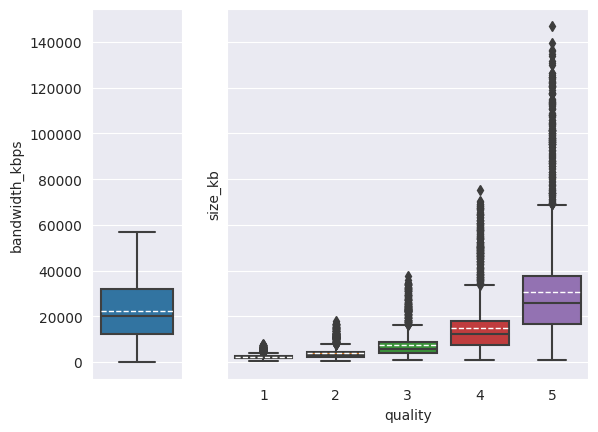

scaled bus_0003


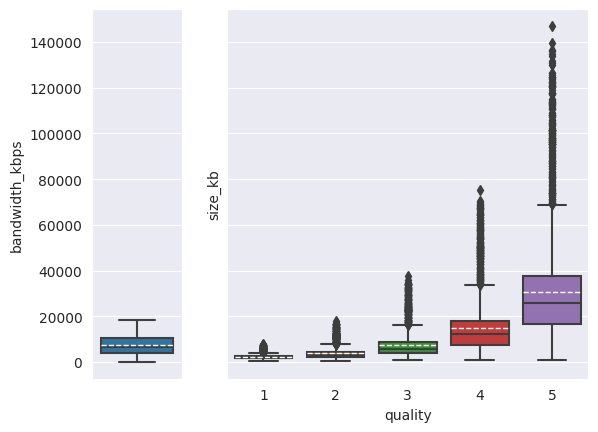

raw bus_0004


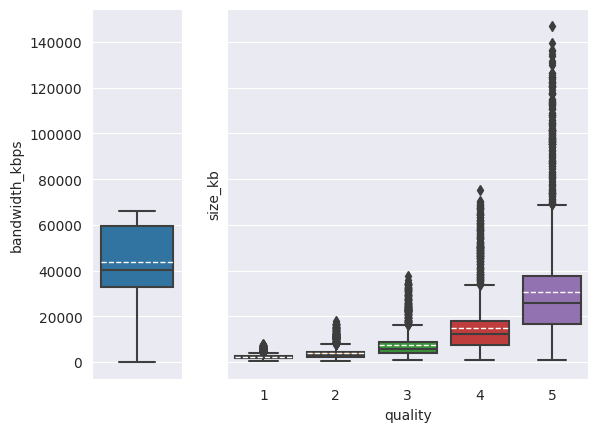

scaled bus_0004


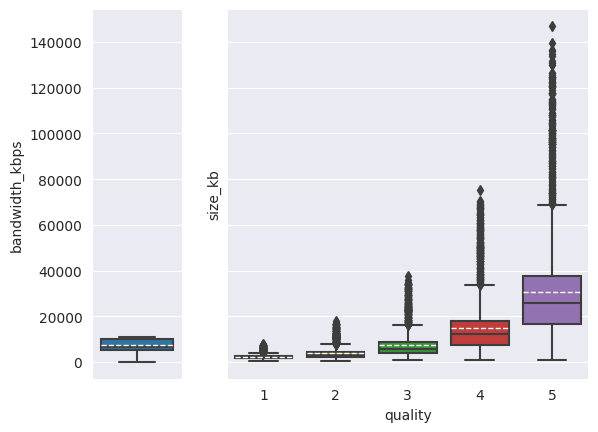

raw bus_0005


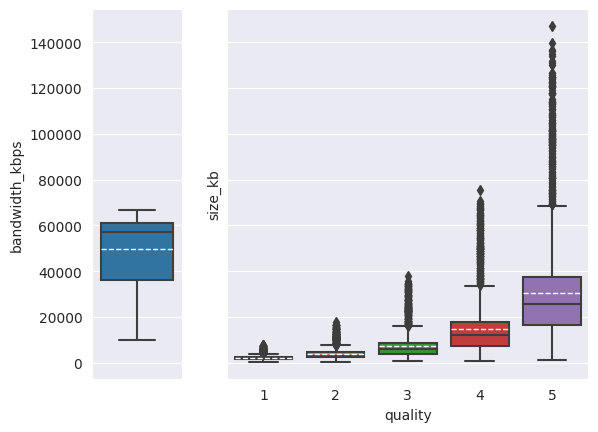

scaled bus_0005


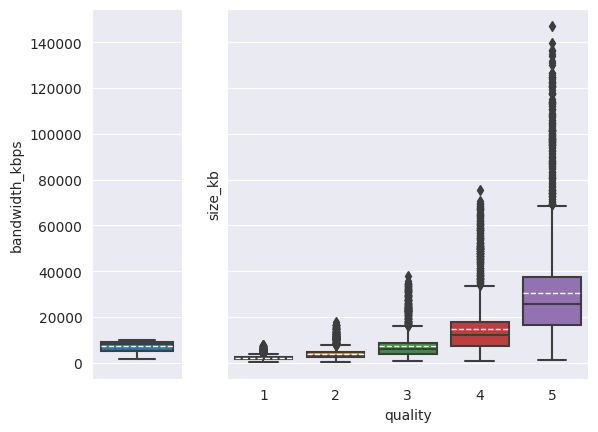

raw bus_0006


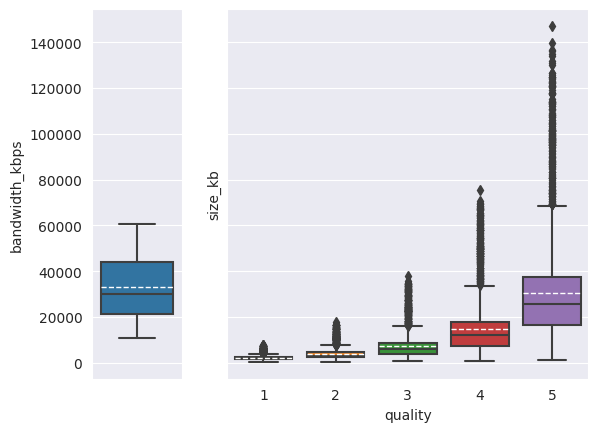

scaled bus_0006


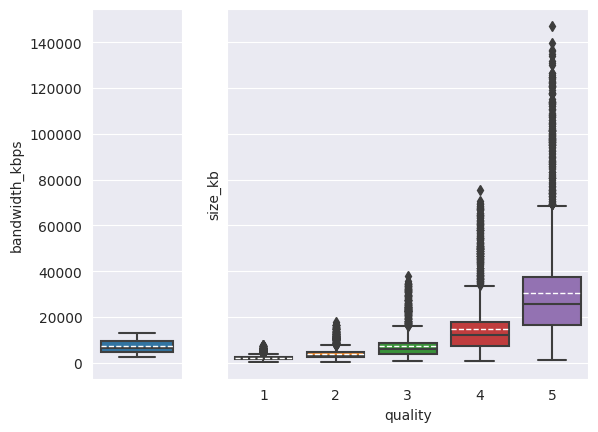

raw bus_0007


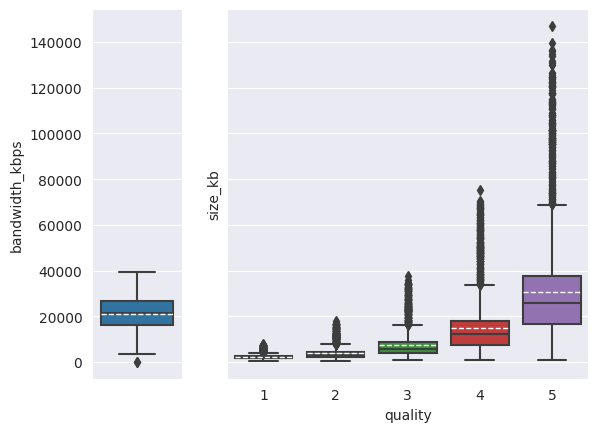

scaled bus_0007


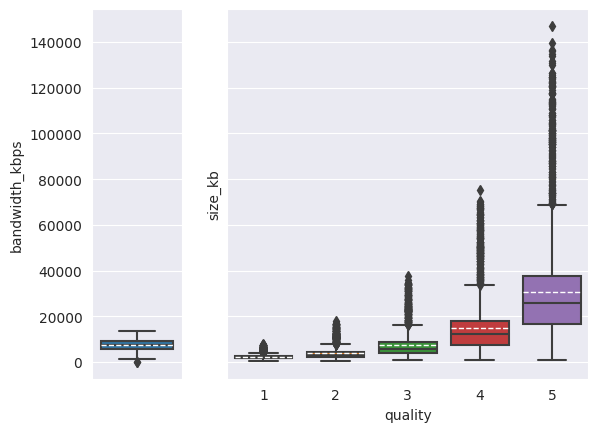

raw bus_0008


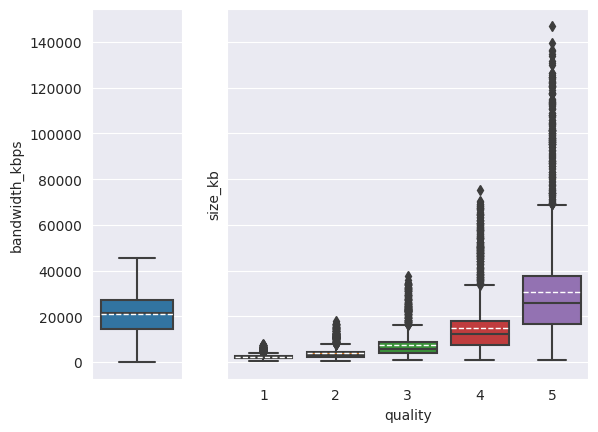

scaled bus_0008


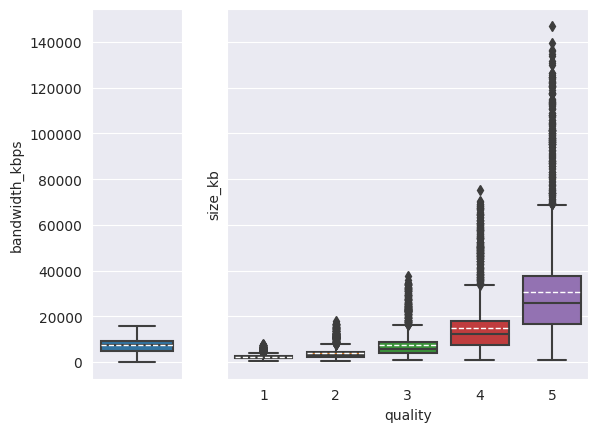

raw bus_0009


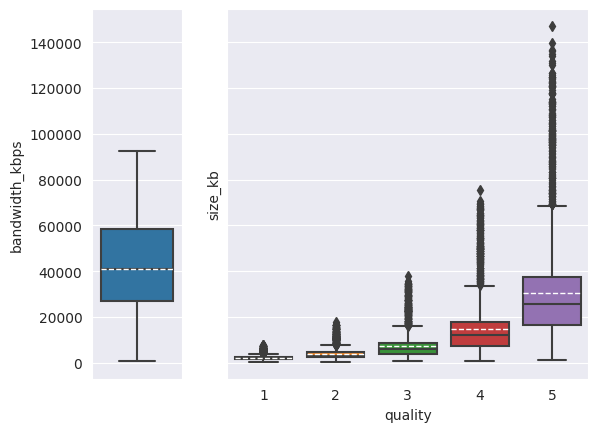

scaled bus_0009


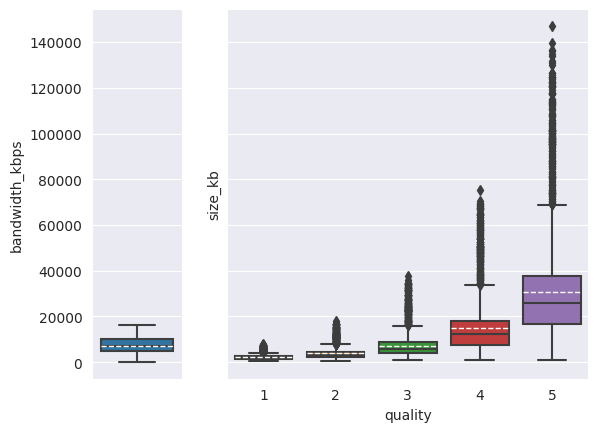

raw bus_0010


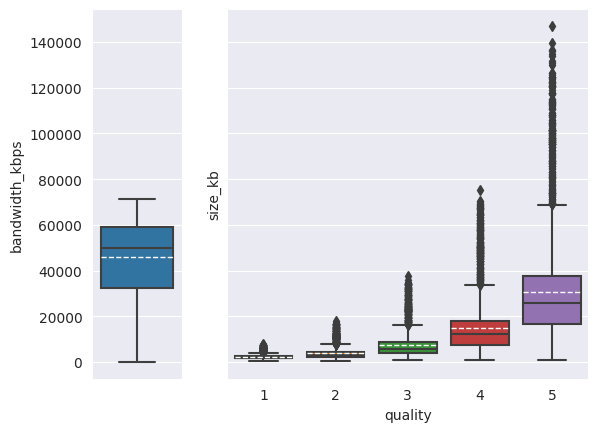

scaled bus_0010


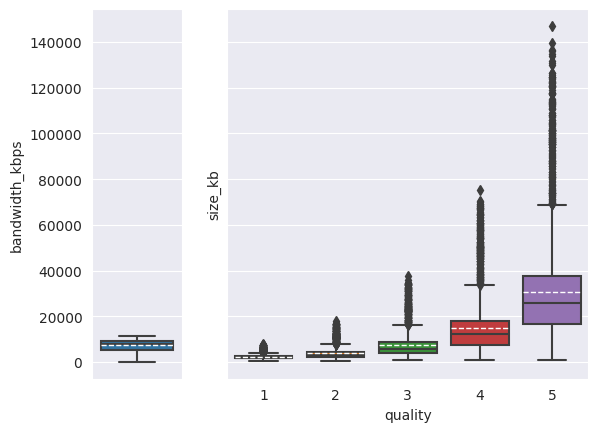

raw bus_0011


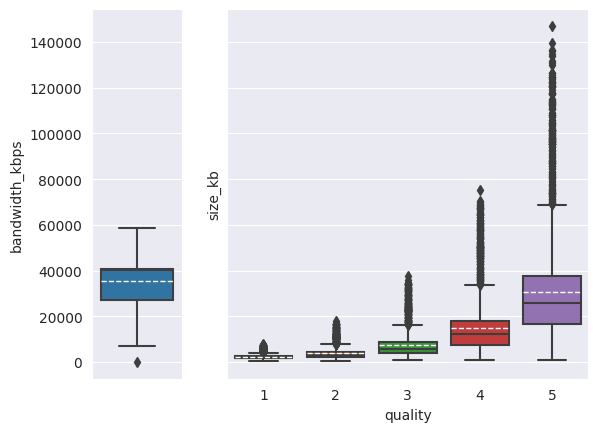

scaled bus_0011


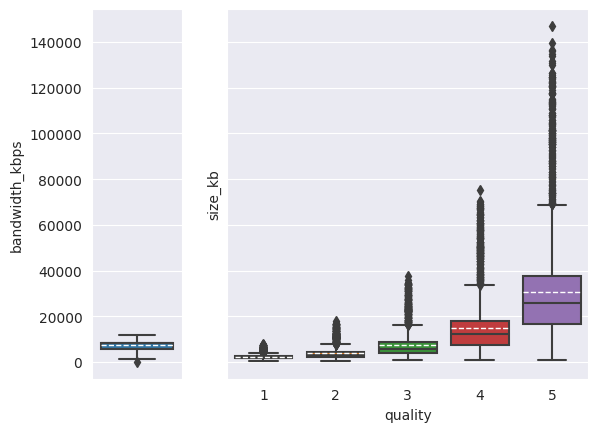

raw car_0001


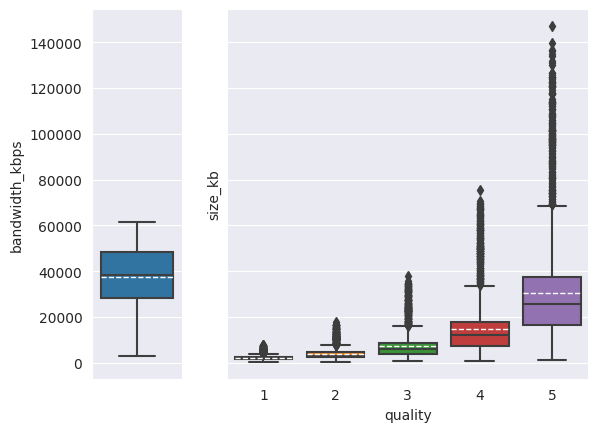

scaled car_0001


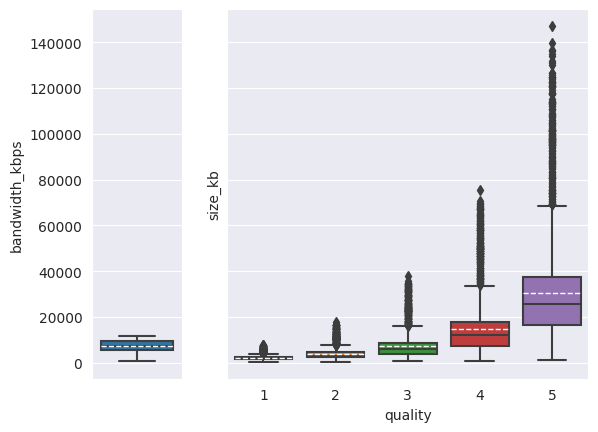

raw car_0002


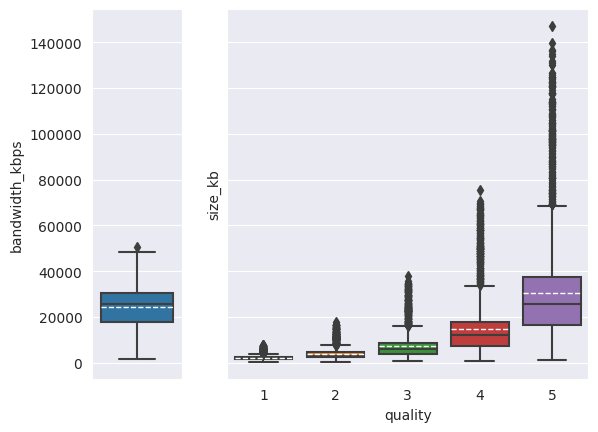

scaled car_0002


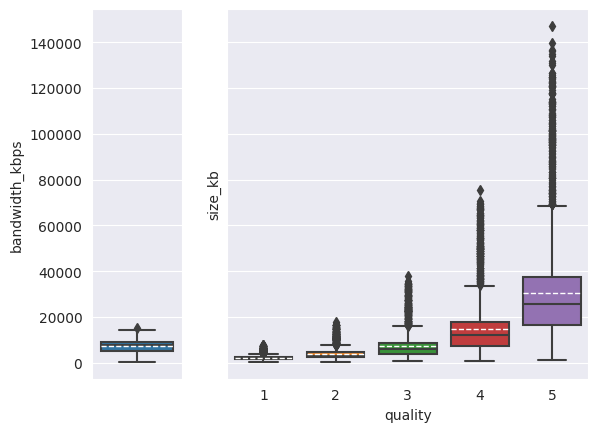

raw car_0003


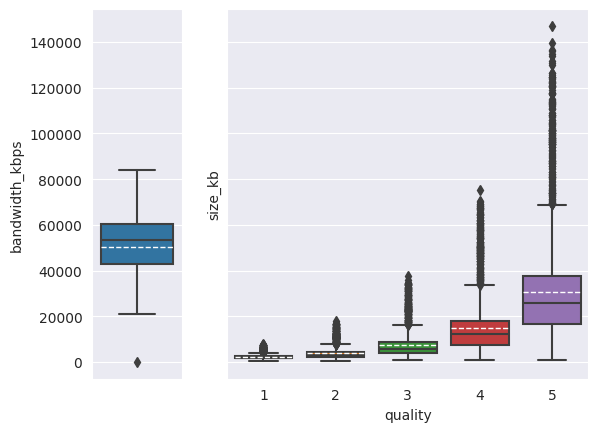

scaled car_0003


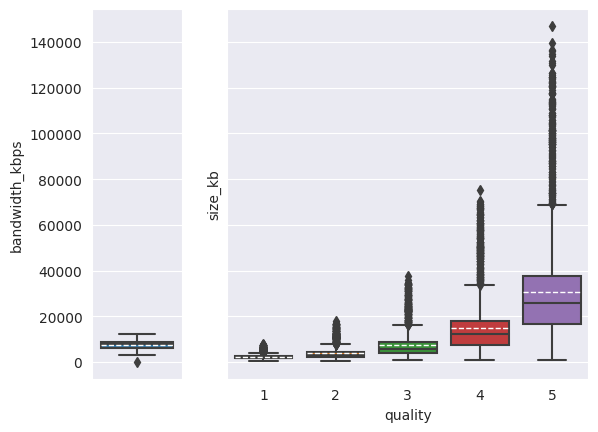

raw car_0004


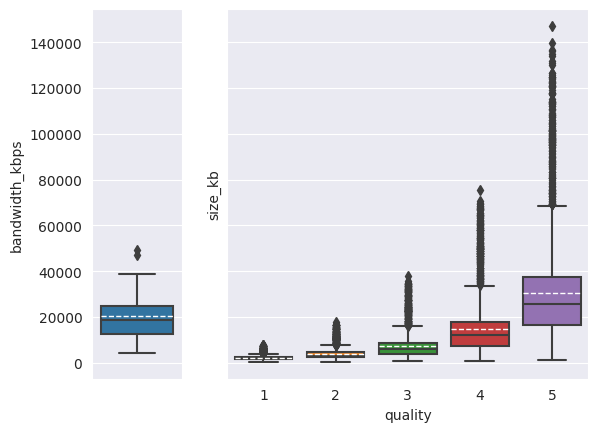

scaled car_0004


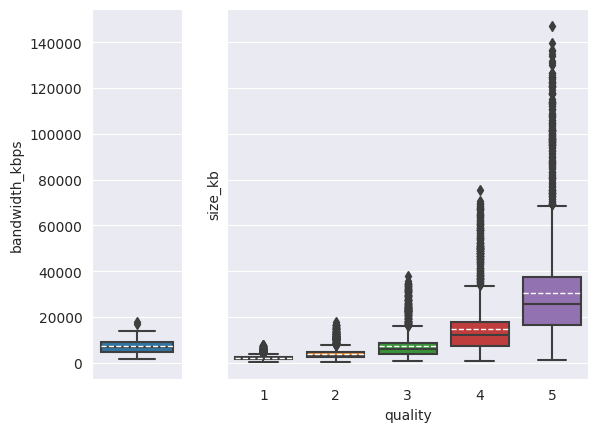

raw car_0005


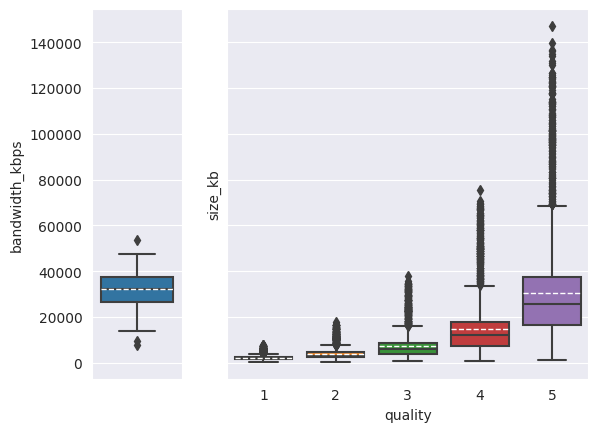

scaled car_0005


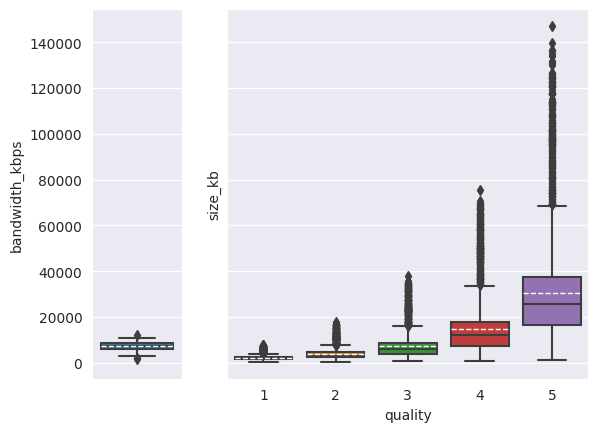

raw car_0006


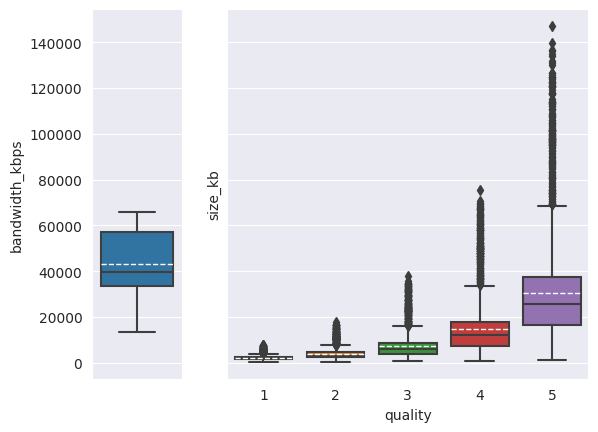

scaled car_0006


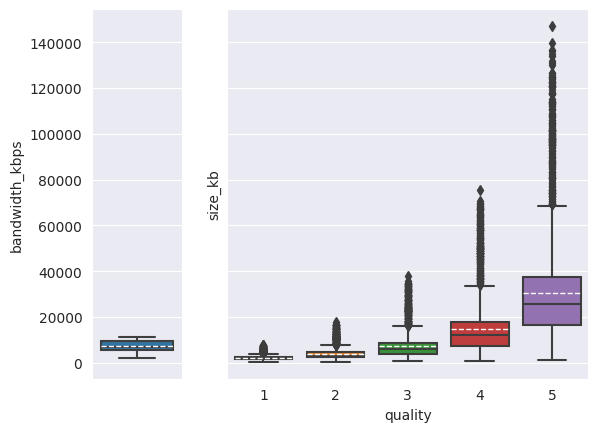

raw car_0007


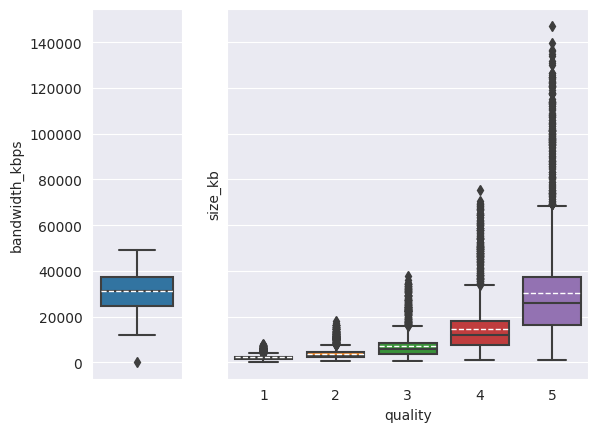

scaled car_0007


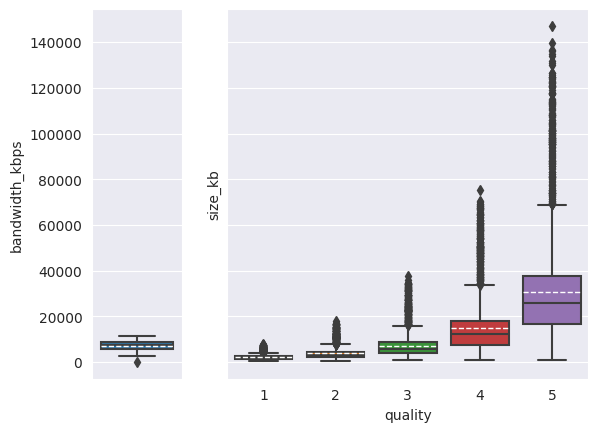

raw car_0008


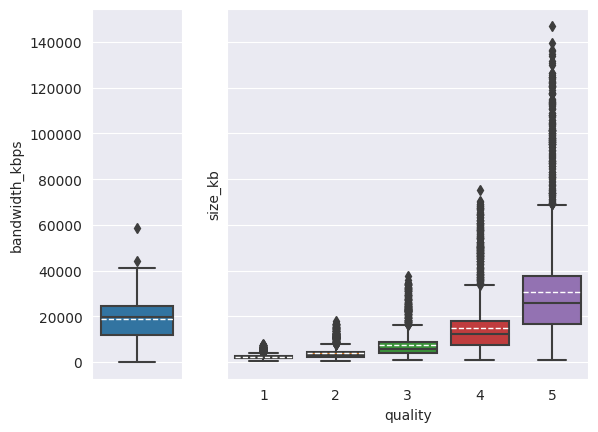

scaled car_0008


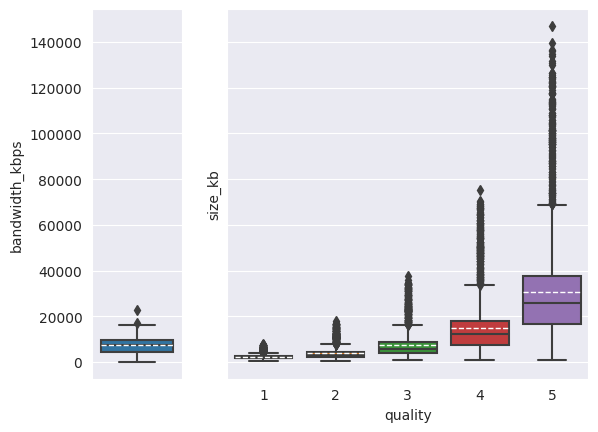

raw foot_0001


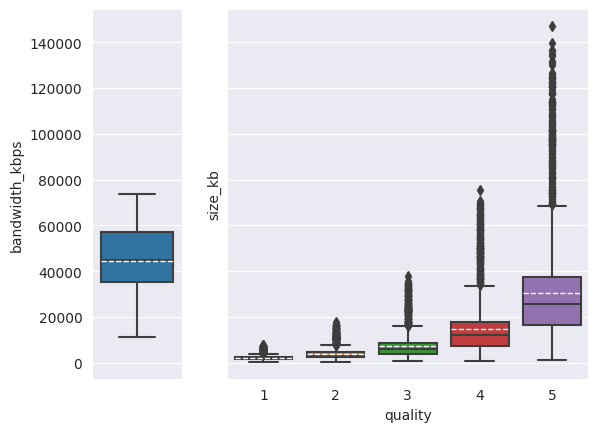

scaled foot_0001


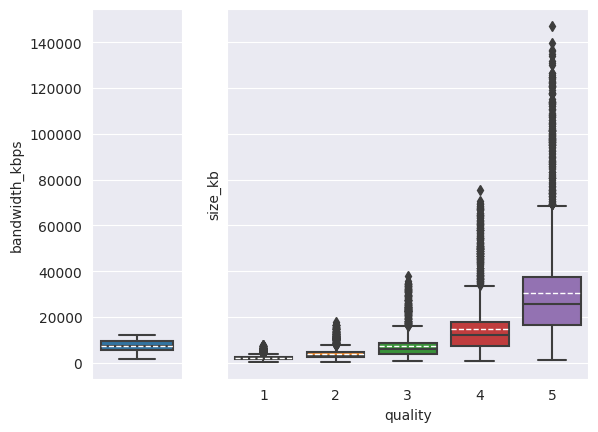

raw foot_0002


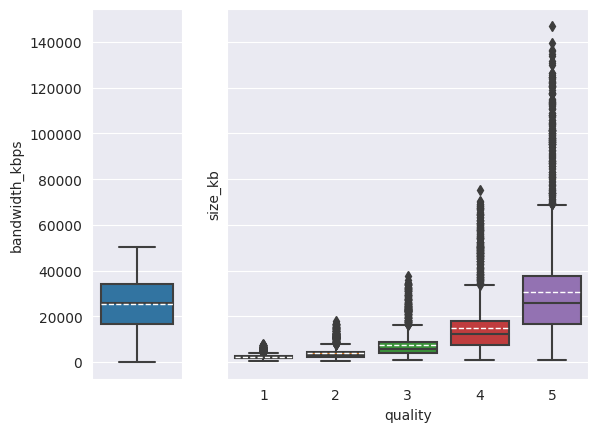

scaled foot_0002


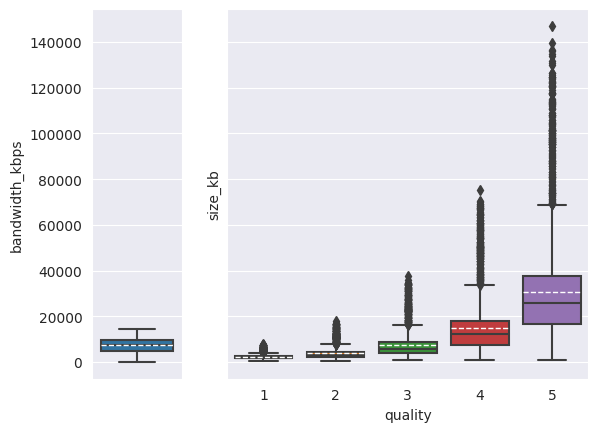

raw foot_0003


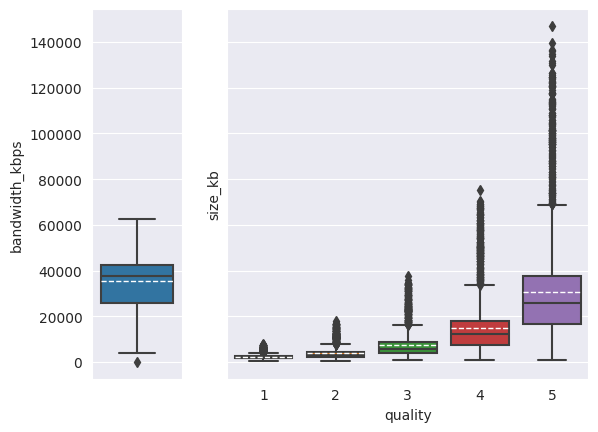

scaled foot_0003


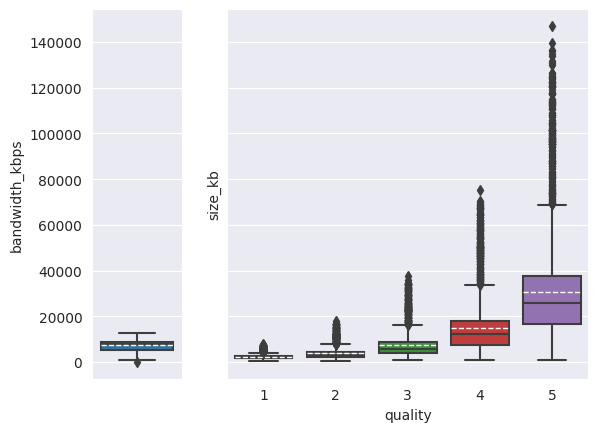

raw foot_0004


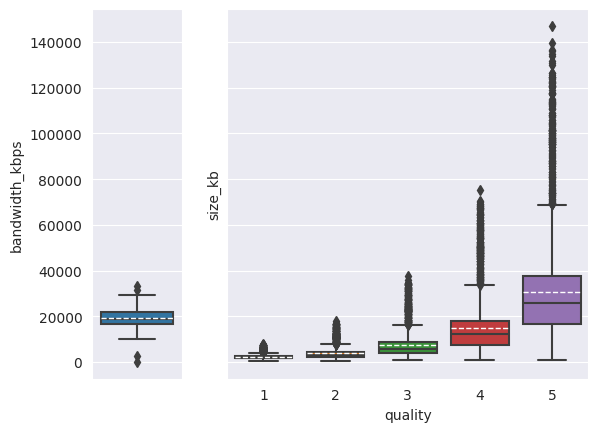

scaled foot_0004


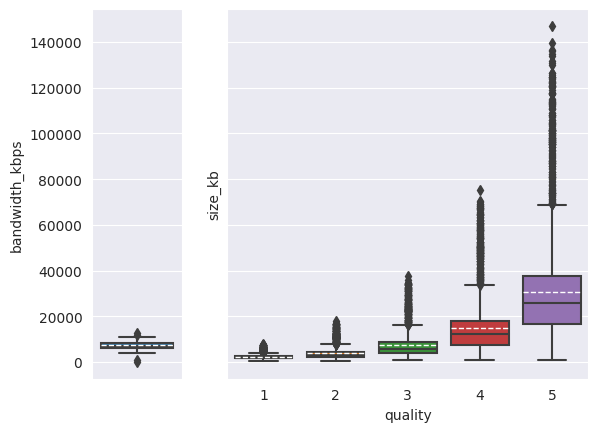

raw foot_0005


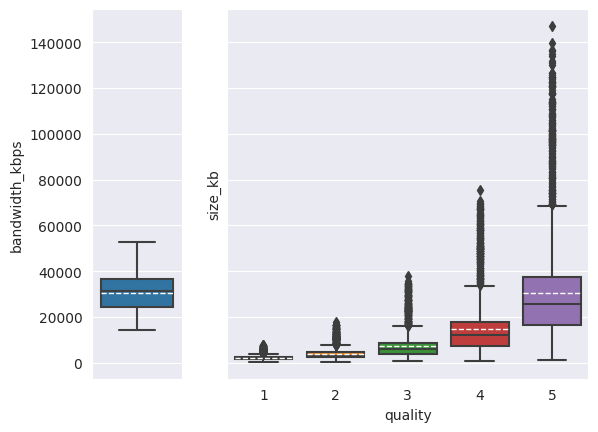

scaled foot_0005


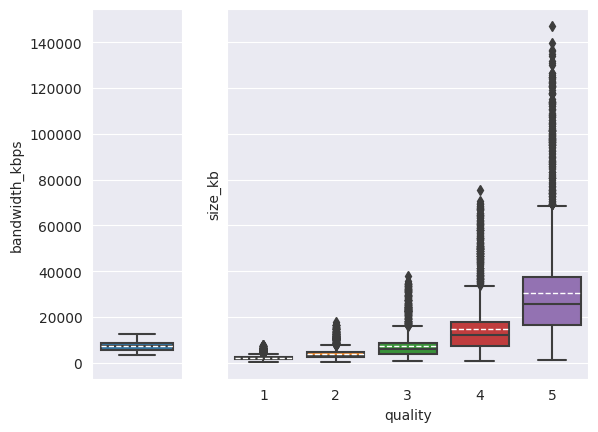

raw foot_0006


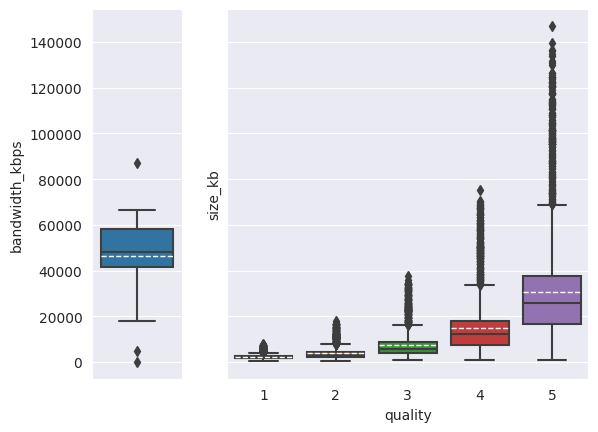

scaled foot_0006


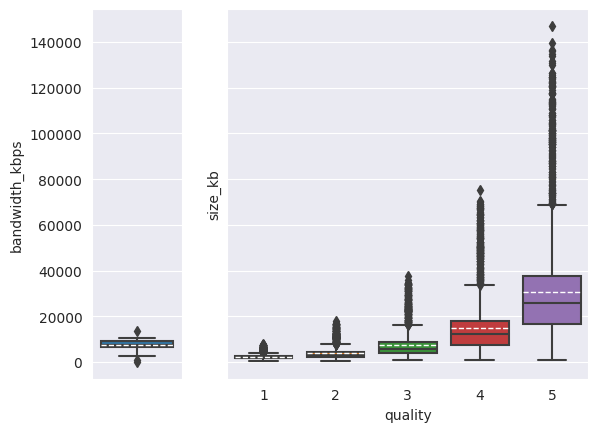

raw foot_0007


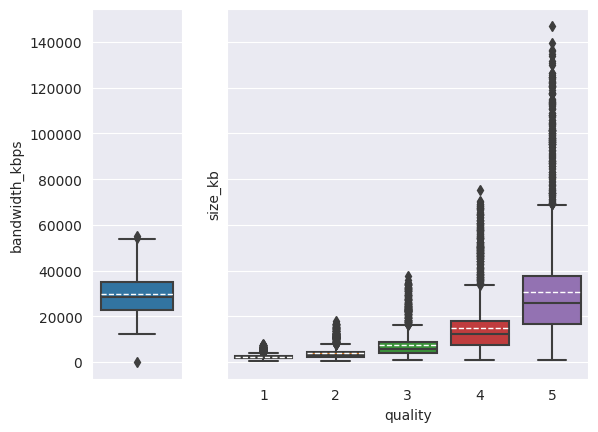

scaled foot_0007


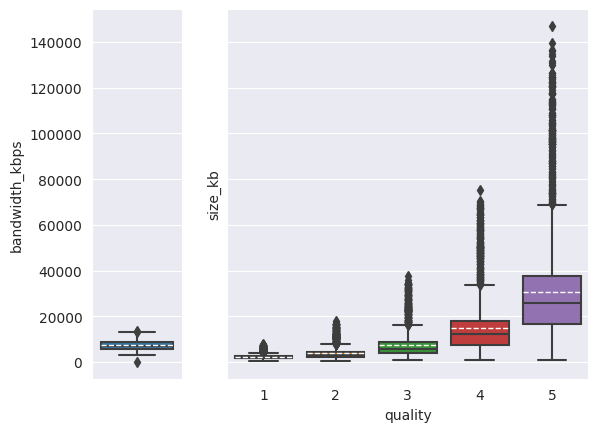

raw foot_0008


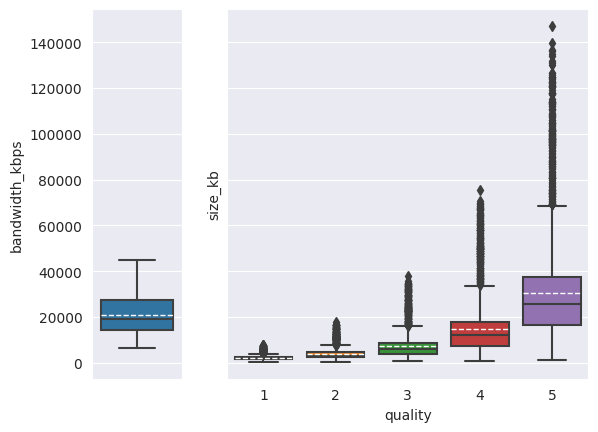

scaled foot_0008


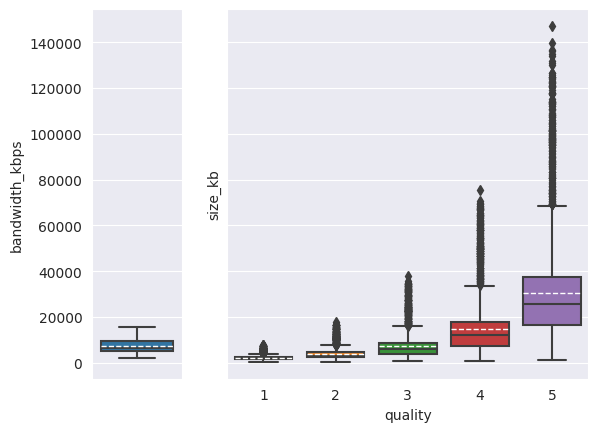

raw train_0001


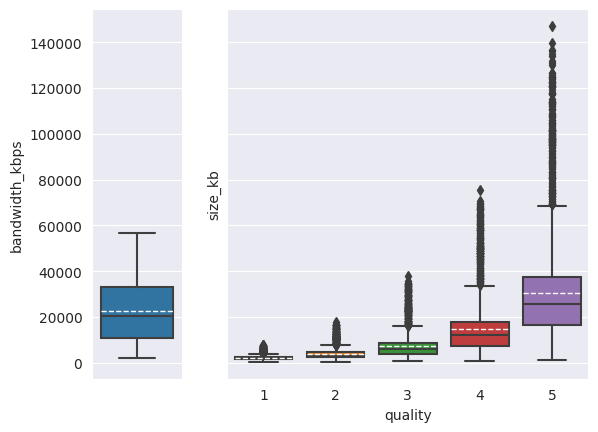

scaled train_0001


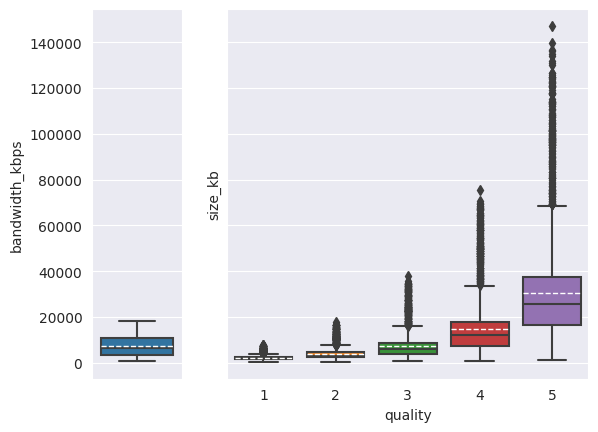

raw train_0002


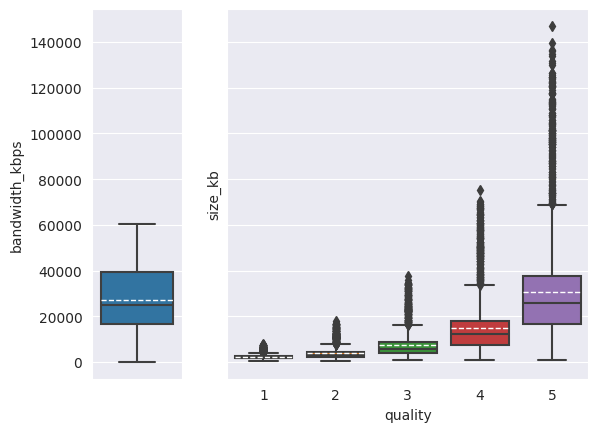

scaled train_0002


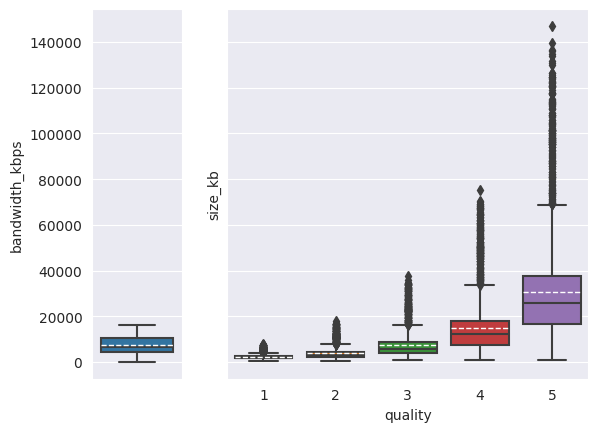

raw train_0003


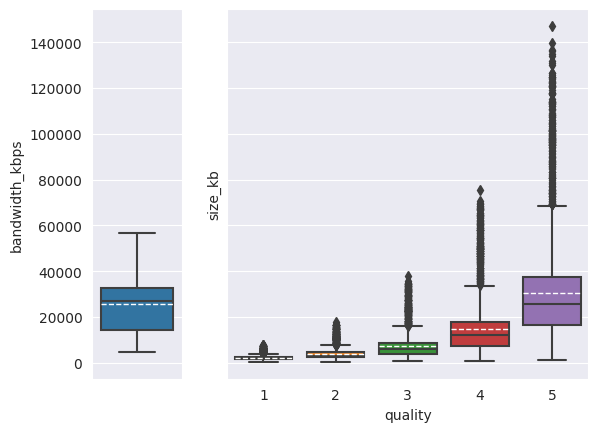

scaled train_0003


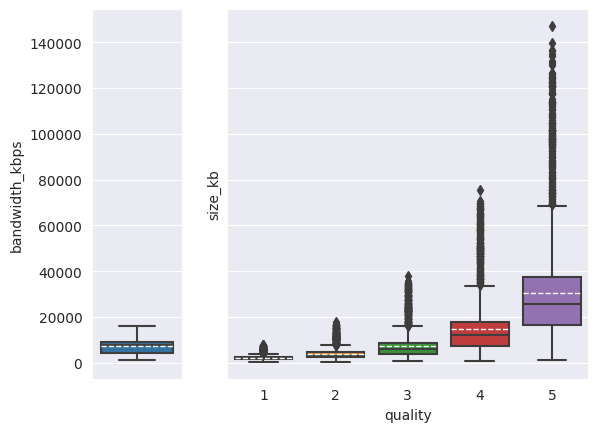

raw tram_0001


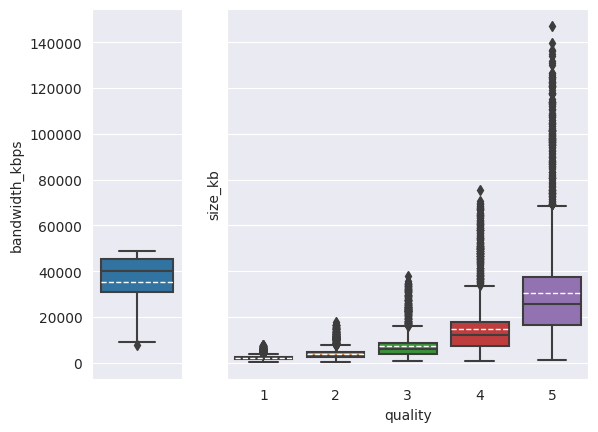

scaled tram_0001


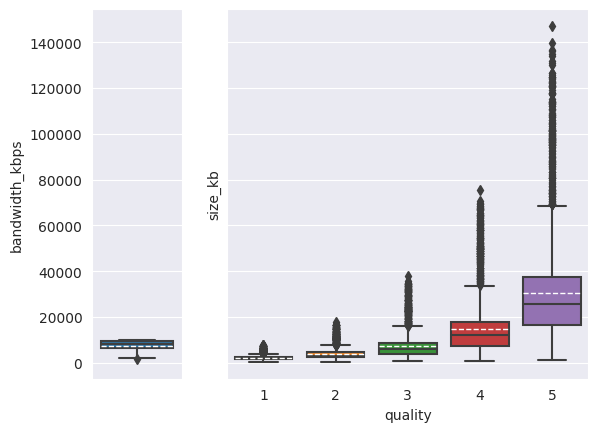

raw tram_0002


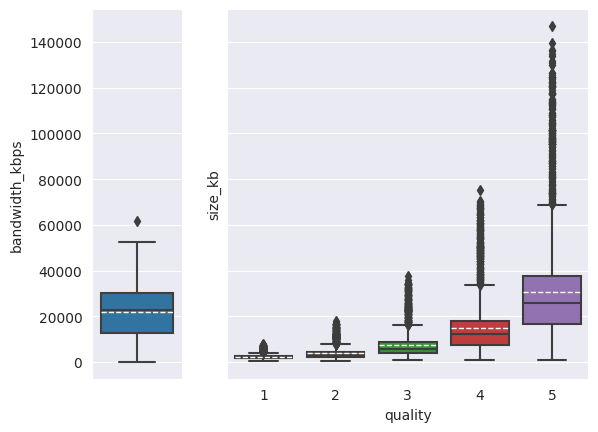

scaled tram_0002


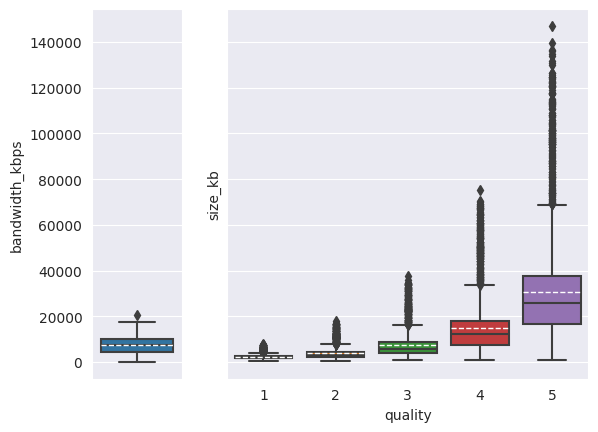

raw tram_0003


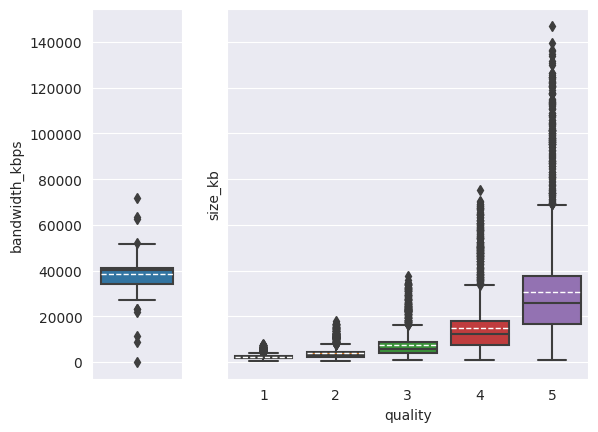

scaled tram_0003


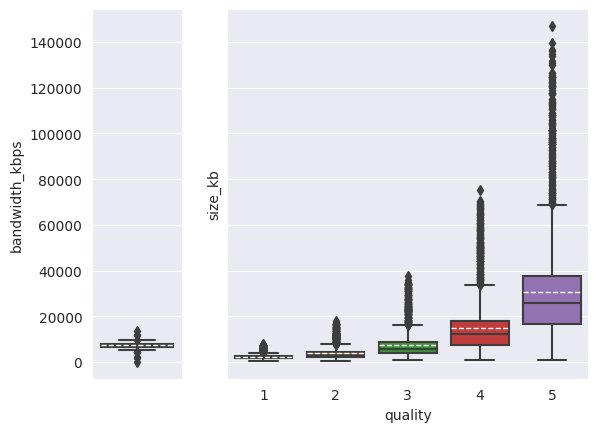

raw tram_0004


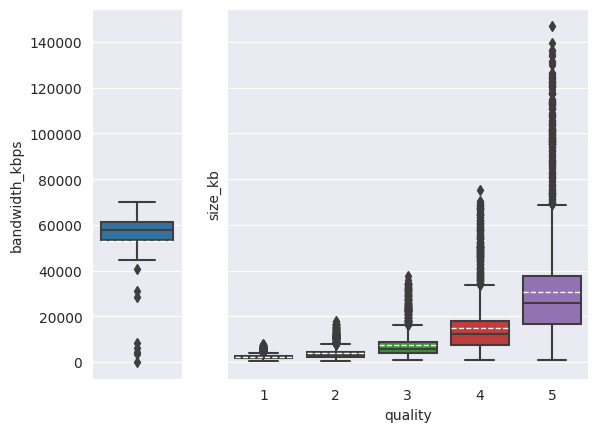

scaled tram_0004


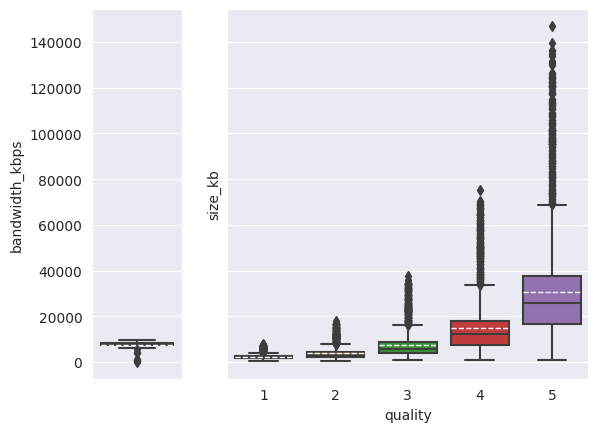

raw tram_0005


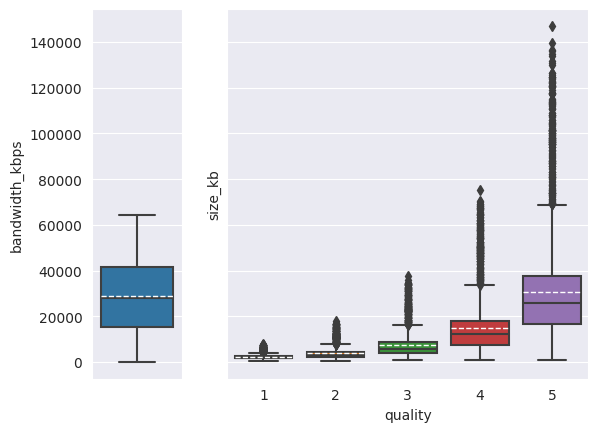

scaled tram_0005


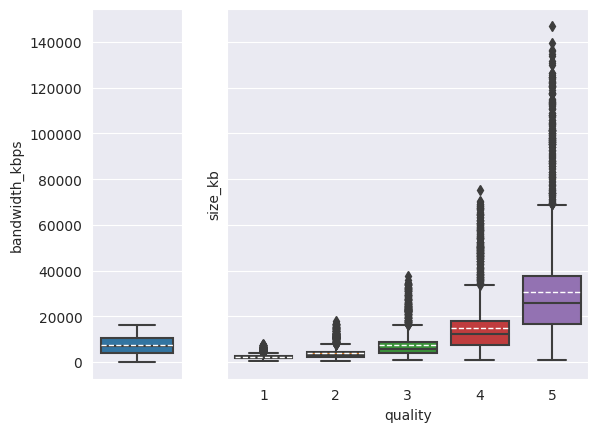

raw tram_0006


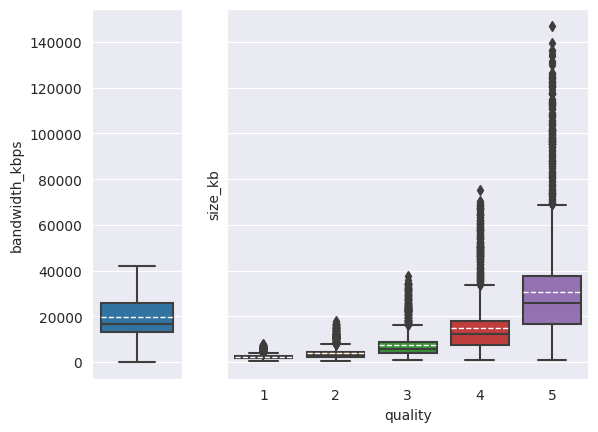

scaled tram_0006


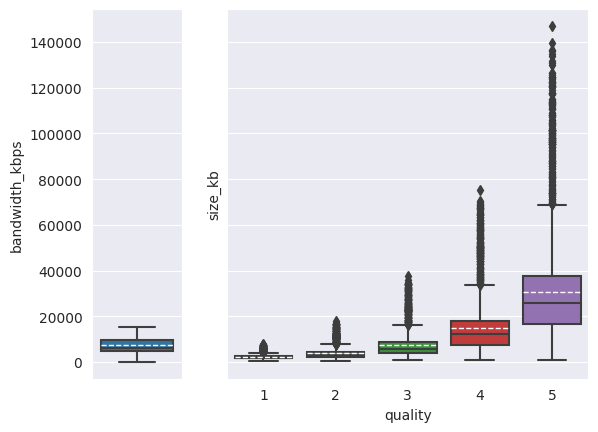

raw tram_0007


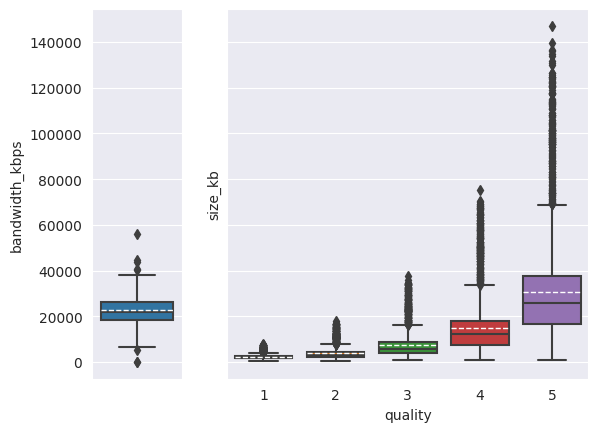

scaled tram_0007


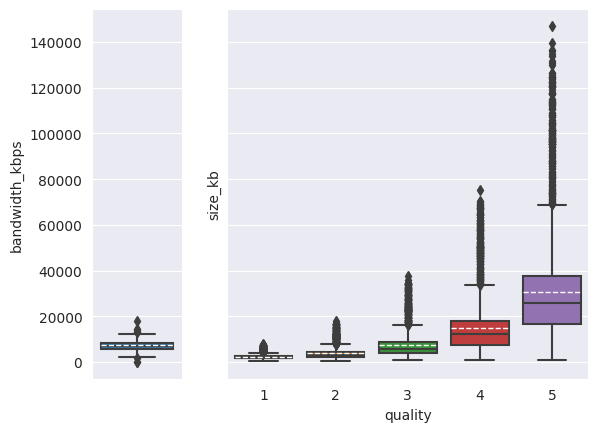

raw tram_0008


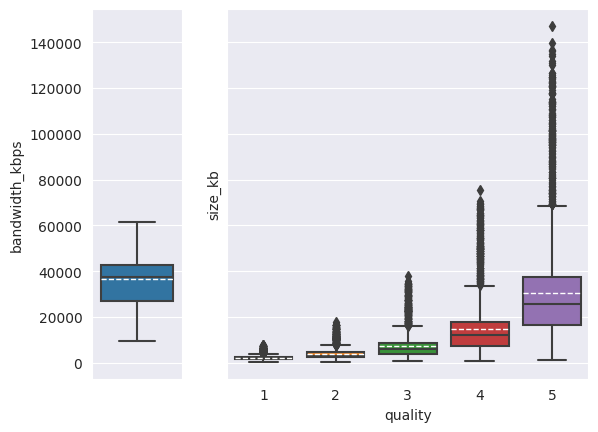

scaled tram_0008


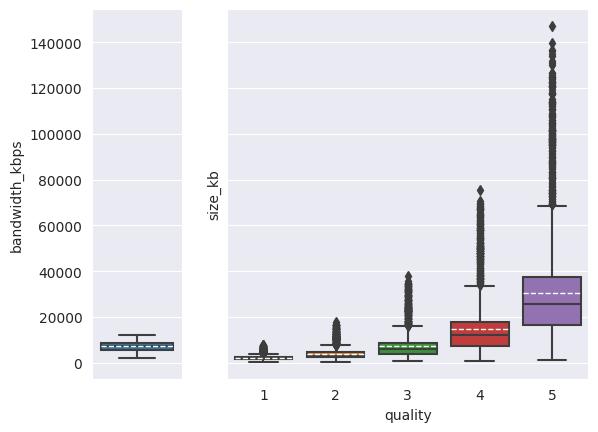

In [5]:
network_traces = sorted(df_network['name'].unique())
df_video_grouped_tiles = df_video.drop(columns=['tile']).groupby(['video', 'segment', 'quality', 'timestamp'], as_index=False).sum()
for network_trace in network_traces:
    print('raw ' + network_trace)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, width_ratios=[1, 4])
    df_network_t = df_network[df_network['name']==network_trace]
    sns.boxplot(data=df_network_t, y='bandwidth_kbps', showmeans=True, meanline=True, meanprops={'color': 'white'}, ax=ax1)
    sns.boxplot(data=df_video_grouped_tiles, y='size_kb', x='quality', showmeans=True, meanline=True, meanprops={'color': 'white'}, ax=ax2)
    plt.show()

    df_network.loc[df_network['name']==network_trace, 'bandwidth_kbps'] /= df_network_t['bandwidth_kbps'].mean()
    df_network.loc[df_network['name']==network_trace, 'bandwidth_kbps'] *= df_video_grouped_tiles[df_video_grouped_tiles['quality']==3]['size_kb'].mean()

    print('scaled ' + network_trace)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True, width_ratios=[1, 4])
    df_network_t = df_network[df_network['name']==network_trace]
    sns.boxplot(data=df_network_t, y='bandwidth_kbps', showmeans=True, meanline=True, meanprops={'color': 'white'}, ax=ax1)
    sns.boxplot(data=df_video_grouped_tiles, y='size_kb', x='quality', showmeans=True, meanline=True, meanprops={'color': 'white'}, ax=ax2)
    plt.show()

In [6]:
for network_trace in network_traces:
    with open(f'../config/real/network_traces/scaled/{network_trace}.json', 'w') as f:
        json.dump(df_network[df_network['name']==network_trace].drop(columns=['timestamp', 'name']).to_dict(orient='records'), f)